## Final Project Submission

Please fill out:
* Student name:  Kevin Machine
* Student pace:  Part Time
* Scheduled project review date/time: April 29, 2020
* Instructor name: Eli Thomas
* Blog post URL: https://machkev.github.io/


## Overview

Microsoft wants to create a new movie studio and create original video content like the big film companies. To this end, they first want to understand how they can successfully enter the movie industry. Our team decided to address the questions on the profitability of movies in relation to movie studios, release time of the movie and the actual language of the movie. The three questions we will attempt to answer with this project are:

-  What are the leading movie studios and production budgets?
-  What are the most popular genre amongst foreign language movies?
-  What season is the most profitable to release a movie?


## Import Libraries

We'll be importing all of the necessary libraries in order to import and convert our files into SQL tables,and importing the csv and tsv files so we can join and run SQL queries on them.

In [5]:
import pandas as pd #importing data analysis library
import numpy as np #importing scientific computation library
import os #importing module so we can interface with our computer and pull file paths
import matplotlib.pyplot as plt #importing basic plotting library
%matplotlib inline
import seaborn as sns #importing advanced plotting library
from glob import glob #importing module to generate pathnames
import sqlite3 # importing SQL

## Import our Data and Create Tables

In [6]:
#create a list of the data we will be reading
csv_files = glob('./zippedData/*.csv.gz')
tsv_files = glob('./zippedData/*.tsv.gz')
files = csv_files + tsv_files
type(files)

list

In [7]:
#clean file name
#create dictionary of dataframes of each csv and tsv
files_dict = {}
for filename in files:
    if 'csv' in str(os.path.basename(filename)):
        filename_cleaned = os.path.basename(filename).replace(".csv.gz", "")\
        .replace(".", "_")
        filename_df = pd.read_csv(filename, compression='gzip', index_col=0)
        files_dict[filename_cleaned] = filename_df
    else:
        filename_cleaned = os.path.basename(filename).replace(".tsv.gz", "")\
        .replace(".", "_")
        filename_df = pd.read_csv\
        (filename, compression='gzip', delimiter ='\t', index_col=0, encoding ='ISO-8859-1')
        files_dict[filename_cleaned] = filename_df

In [8]:
#view file names from k:v pairs in our dictionary
files_dict.keys()

dict_keys(['imdb_title_crew', 'tmdb_movies', 'imdb_title_akas', 'imdb_title_ratings', 'imdb_name_basics', 'imdb_title_basics', 'tn_movie_budgets', 'bom_movie_gross', 'imdb_title_principals', 'rt_reviews', 'rt_movie_info'])

In [10]:
#check key in the dictionary to ensure that dataframes have been created 
files_dict['rt_movie_info'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 1 to 2000
Data columns (total 11 columns):
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: object(11)
memory usage: 146.2+ KB


In [11]:
#connect to new database
conn = sqlite3.connect("movies_db.sqlite")

In [12]:
#create function to create a SQL table passing a dataframe, name, and 
#connection to database
def create_sql_table_from_df(df, name, conn):
    try:
        df.to_sql(name, conn)
        print(f"Created table {name}")
    except Exception as e:
        print(f"could not make table {name}")
        print(e)

In [13]:
#pass the function through a for loop of the tables and names in our 
#dictionary of csv files
for name, table in files_dict.items():
    create_sql_table_from_df(table, name, conn)

could not make table imdb_title_crew
Table 'imdb_title_crew' already exists.
could not make table tmdb_movies
Table 'tmdb_movies' already exists.
could not make table imdb_title_akas
Table 'imdb_title_akas' already exists.
could not make table imdb_title_ratings
Table 'imdb_title_ratings' already exists.
could not make table imdb_name_basics
Table 'imdb_name_basics' already exists.
could not make table imdb_title_basics
Table 'imdb_title_basics' already exists.
could not make table tn_movie_budgets
Table 'tn_movie_budgets' already exists.
could not make table bom_movie_gross
Table 'bom_movie_gross' already exists.
could not make table imdb_title_principals
Table 'imdb_title_principals' already exists.
could not make table rt_reviews
Table 'rt_reviews' already exists.
could not make table rt_movie_info
Table 'rt_movie_info' already exists.


In [14]:
#create a cursor to do a query of our sql db
cur = conn.cursor()

In [15]:
#testing connection on our database of tables
conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('imdb_title_crew',),
 ('tmdb_movies',),
 ('imdb_title_akas',),
 ('imdb_title_ratings',),
 ('imdb_name_basics',),
 ('imdb_title_basics',),
 ('tn_movie_budgets',),
 ('bom_movie_gross',),
 ('imdb_title_principals',),
 ('rt_reviews',),
 ('rt_movie_info',),
 ('budgets_release_dates',),
 ('non_en_movie_details',),
 ('top_10_studios',)]

## Q1:  What season is the most profitable to release a movie?


## EDA for Profit and Release Dates

We will clean the data and add relevant columns by determining the profit of each movie, the month of release, ensuring the data types are correct, and remove duplicates.

In [16]:
#create a dataframe from the movie budgets file
budgets_and_release_dates_df = files_dict['tn_movie_budgets']

In [17]:
#Check out the columns
budgets_and_release_dates_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [18]:
#review the data types
budgets_and_release_dates_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: object(5)
memory usage: 271.0+ KB


In [19]:
#change datatype of release date to a datetime object to extract the month
budgets_and_release_dates_df['release_date'] = pd.to_datetime\
                                (budgets_and_release_dates_df['release_date'])

In [20]:
#change datatype of the budget and gross columns to int64
budgets_and_release_dates_df[budgets_and_release_dates_df.columns[2:]] \
        = budgets_and_release_dates_df[budgets_and_release_dates_df.columns[2:]]\
        .apply(lambda x: x.str.replace('$',''))\
        .apply(lambda x: x.str.replace(',','')).astype(np.int64)

In [21]:
#create profit column subtracting budget from worldwide gross
budgets_and_release_dates_df['movie_profit'] \
        = budgets_and_release_dates_df['worldwide_gross']\
        - budgets_and_release_dates_df['production_budget']

In [22]:
#check out the data and confirm datatype changes
budgets_and_release_dates_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_profit
id,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


In [23]:
#create month column so we can plot it against profit
budgets_and_release_dates_df['release_month'] = \
        pd.DatetimeIndex(budgets_and_release_dates_df['release_date']).month

In [24]:
#check to ensure no duplicate rows
duplicate_budgets_and_release_dates_df = \
        budgets_and_release_dates_df[budgets_and_release_dates_df.duplicated()]

In [25]:
#review dataframe of duplicate rows
duplicate_budgets_and_release_dates_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_profit,release_month
id,,,,,,,


In [26]:
#check to ensure release month column was inserted correctly
budgets_and_release_dates_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_profit,release_month
id,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,12
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,5
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,6
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,5
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,12


In [27]:
#check for earliest value in our datetime column
budgets_and_release_dates_df['release_date'].min()

Timestamp('1915-02-08 00:00:00')

In [30]:
#check for number of entries
budgets_and_release_dates_df.shape

(5782, 7)

## Data Review

We will review the data using an SQL query to get a better sense of the scale of the profit numbers.

In [ ]:
#create SQL table to run a query of our data (not run in this instance since 
#table had been created in prior kernel and produces an error message)
budgets_and_release_dates_df.to_sql('budgets_release_dates', conn)

In [32]:
cur.execute("""SELECT movie_profit, release_month
            FROM budgets_release_dates
            WHERE release_date > 2000-01-01
            ORDER BY movie_profit DESC;""").fetchall()

[(2351345279, 12),
 (2008208395, 12),
 (1748134200, 4),
 (1747311220, 12),
 (1433854864, 6),
 (1328722794, 4),
 (1292935897, 5),
 (1216693157, 7),
 (1148258224, 2),
 (1135772799, 6),
 (1122469910, 11),
 (1099199706, 3),
 (1086336173, 7),
 (1072413963, 5),
 (1047403341, 12),
 (1042520711, 6),
 (1015392272, 5),
 (999721747, 12),
 (986894640, 12),
 (984846267, 4),
 (975812584, 6),
 (959727750, 6),
 (948061550, 3),
 (928790543, 6),
 (912044677, 5),
 (910526981, 11),
 (906914868, 6),
 (899216835, 7),
 (894039076, 6),
 (890069413, 5),
 (874496193, 12),
 (869429616, 3),
 (868879522, 6),
 (867008132, 5),
 (850047606, 11),
 (849102856, 12),
 (842429370, 5),
 (841215812, 7),
 (840699645, 12),
 (839985342, 11),
 (835431568, 11),
 (825491110, 3),
 (821215193, 6),
 (816996207, 7),
 (811750534, 7),
 (809439099, 7),
 (793076457, 7),
 (787854547, 4),
 (784765137, 7),
 (782465326, 6),
 (779225135, 11),
 (778210985, 12),
 (775598007, 5),
 (769701857, 7),
 (767003568, 12),
 (747099794, 11),
 (743025593, 

In [33]:
budgets_and_release_dates_df.groupby('release_month').mean()

,production_budget,domestic_gross,worldwide_gross,movie_profit
release_month,,,,
1,2.084349e+07,2.394962e+07,4.656382e+07,2.572033e+07
2,2.804642e+07,3.541465e+07,7.154453e+07,4.349811e+07
3,3.078208e+07,3.857299e+07,8.063337e+07,4.985129e+07
4,2.380283e+07,2.732840e+07,5.992026e+07,3.611743e+07
5,4.713520e+07,6.669795e+07,1.622680e+08,1.151328e+08
6,4.309912e+07,6.582791e+07,1.425230e+08,9.942391e+07
7,4.254616e+07,6.072804e+07,1.409636e+08,9.841746e+07
8,2.555609e+07,3.216821e+07,6.097841e+07,3.542232e+07
9,2.181290e+07,2.314989e+07,4.669369e+07,2.488078e+07


In [34]:
#run an SQL query for movie profit by month
cur.execute("""SELECT avg(movie_profit), release_month
            FROM budgets_release_dates
            GROUP BY release_month
            ORDER BY avg(movie_profit) DESC;""").fetchall()

[(115132808.4004914, 5),
 (99423910.9519833, 6),
 (98417458.35909091, 7),
 (93141569.2510288, 11),
 (68441565.30604027, 12),
 (49851292.36170213, 3),
 (43498106.821428575, 2),
 (36117428.171806164, 4),
 (35422316.85685484, 8),
 (29071903.781849913, 10),
 (25720334.109510086, 1),
 (24880784.866125762, 9)]

## Data Visualization

We will plot our data using a boxplot to show the profits for each month. We use a boxplot so that we can see the IQR for movie profits and how the vary from month to month. We will also remove the outliers but leave in the whiskers to get a good sense of the full range of movie success by month.

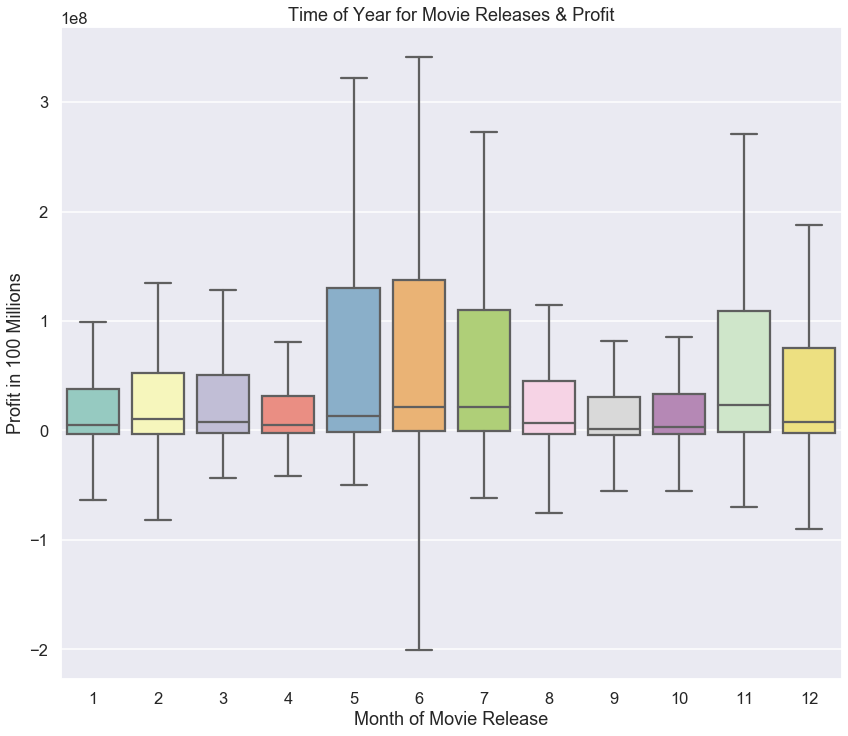

In [124]:
#create a boxplot using release month and profit
x = budgets_and_release_dates_df['release_month']
y = budgets_and_release_dates_df['movie_profit']
f, ax = plt.subplots(figsize=(14,12))
sns.set_style('darkgrid')
sns.set_context('talk') 
sns.boxplot(x, y, palette='Set3', showfliers=False)
plt.title('Time of Year for Movie Releases & Profit')
plt.ylabel('Profit in 100 Millions')
plt.xlabel('Month of Movie Release') 
plt.show()

## Findings

From our boxplot, we see there's dual seasonality of higher profits during the summer and at the end of the year. The highest profit in summer can be realized during the months of June and in November toward the winter months.

## Recommendations

Microsoft should take into account the seasonality of profits and target movies to be released in May or June to ensure a higher likelihood of it being a hit.

## Future Work
We should continue to track by genre what the best time is for a movie release, or examine the ROI for movies in certain genres.

## Q2 :  What are the most popular genres amongst foreign language movies?

Turning to the genre and viewership of movies, there has been an increasing recognition and viewership towards non-English films over the last years. In the event Microsoft decides to pursue the independent or film-right acquisition at festivals, this analysis would help in building confidence on how to select a genre type and whether it would be profitable.

## EDA for non-English genres and popularity rating

In [36]:
#title basics dataframe has our info on genres, and tmbd movies has the list of 
#non-English language movies 
movie_genres_df = files_dict['imdb_title_basics']

In [37]:
#check columns and column ids
movie_genres_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [38]:
#check datatypes in the df with our genres
movie_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146144 entries, tt0063540 to tt9916754
Data columns (total 5 columns):
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 6.7+ MB


In [39]:
#create section non-english df from our tmdb movies dataset
non_EN_popularity_df = files_dict['tmdb_movies']

In [40]:
#view column ids
non_EN_popularity_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [41]:
#confirm the datatypes in this df with non-english movies
non_EN_popularity_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [42]:
#join two dfs on the original title column, an inner join as we only want rows 
#that definitely have genre names and language information in both
non_en_movie_details_df = pd.merge(movie_genres_df, non_EN_popularity_df, \
                        on = ['original_title'], how = 'inner')

In [43]:
#view datatypes and column names for our combined df
non_en_movie_details_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21078 entries, 0 to 21077
Data columns (total 13 columns):
primary_title        21078 non-null object
original_title       21078 non-null object
start_year           21078 non-null int64
runtime_minutes      19452 non-null float64
genres               20779 non-null object
genre_ids            21078 non-null object
id                   21078 non-null int64
original_language    21078 non-null object
popularity           21078 non-null float64
release_date         21078 non-null object
title                21078 non-null object
vote_average         21078 non-null float64
vote_count           21078 non-null int64
dtypes: float64(3), int64(3), object(7)
memory usage: 2.3+ MB


In [44]:
#drop two columns that are irrelevant for our data viewing
#column not run as it produces an error since columns had already been removed
non_en_movie_details_df = non_en_movie_details_df.drop \
                        (columns = ['runtime_minutes', 'genre_ids'])

In [45]:
#remove english as original language films from df
non_en_movie_details_df = non_en_movie_details_df \
                        [non_en_movie_details_df['original_language'] != 'en']

In [46]:
#limit the rows to only those that have over 100 vote counts
non_en_movie_details_df = non_en_movie_details_df[non_en_movie_details_df\
                        ['vote_count'] >= 100]

In [47]:
#drop duplicate rows
non_en_movie_details_df = non_en_movie_details_df.drop_duplicates\
                        (subset = 'id', keep = 'first')

In [48]:
#determine if this dataset is large enough
non_en_movie_details_df.shape

(252, 11)

In [49]:
#determine whether our dataset has data that we can consider "recent"
non_en_movie_details_df['start_year'].min()

2010

In [50]:
#determine the most recent data
non_en_movie_details_df['start_year'].max()

2020

## Data Review

In [51]:
#split out our genre column by commas to create list
non_en_movie_details_df['genres'] = non_en_movie_details_df['genres']\
                                    .apply(lambda x: x.split(","))

In [52]:
#create for loop to fill genre columns with boolean values
for index, row in non_en_movie_details_df.iterrows():
    if row['genres']:
        for genre in row['genres']:
            non_en_movie_details_df.loc[index, genre] = 1

In [53]:
#pull list of genres from the columns we created
cols = list(non_en_movie_details_df.columns[11:])

In [54]:
#viewing to make sure list is correct
cols

['Animation',
 'Drama',
 'Action',
 'Biography',
 'Crime',
 'Adventure',
 'Comedy',
 'Romance',
 'Documentary',
 'Thriller',
 'Horror',
 'Mystery',
 'War',
 'History',
 'Fantasy',
 'Music',
 'Sci-Fi',
 'Family',
 'Musical',
 'Sport',
 'Western']

In [55]:
#create dictionary of genres and counts as k:v pairings using for loop to 
#sum the bools for each genre
genre_and_count_dict = {}
for col in cols:
    count = non_en_movie_details_df[col].sum() 
    genre_and_count_dict[col] = count

In [56]:
#viewing dictionary
genre_and_count_dict

{'Animation': 18.0,
 'Drama': 161.0,
 'Action': 29.0,
 'Biography': 16.0,
 'Crime': 27.0,
 'Adventure': 24.0,
 'Comedy': 84.0,
 'Romance': 51.0,
 'Documentary': 10.0,
 'Thriller': 32.0,
 'Horror': 21.0,
 'Mystery': 19.0,
 'War': 10.0,
 'History': 14.0,
 'Fantasy': 18.0,
 'Music': 6.0,
 'Sci-Fi': 7.0,
 'Family': 5.0,
 'Musical': 1.0,
 'Sport': 1.0,
 'Western': 1.0}

In [57]:
#sort dictionary values and choosing the # of movies at the 10th index (18)
#create dictionar with only the common genres with more than 18 films
#using dictionary comprehension (items) to select k:v pairs where value > 18
sorted_dict = sorted(genre_and_count_dict.values(), reverse=True)[9]
top_10_genre_and_count_dict = {k: v for k, v in genre_and_count_dict.items() 
                                if v >= sorted_dict}

In [58]:
#view the minimum value of our new dictionary
sorted_dict

18.0

In [59]:
#view edited dictionary
top_10_genre_and_count_dict

{'Animation': 18.0,
 'Drama': 161.0,
 'Action': 29.0,
 'Crime': 27.0,
 'Adventure': 24.0,
 'Comedy': 84.0,
 'Romance': 51.0,
 'Thriller': 32.0,
 'Horror': 21.0,
 'Mystery': 19.0,
 'Fantasy': 18.0}

## Data Visualization

In [60]:
#create x and y values to plot our dictionary
x_genre_count = list(top_10_genre_and_count_dict.keys())
y_genre_count = list(top_10_genre_and_count_dict.values())

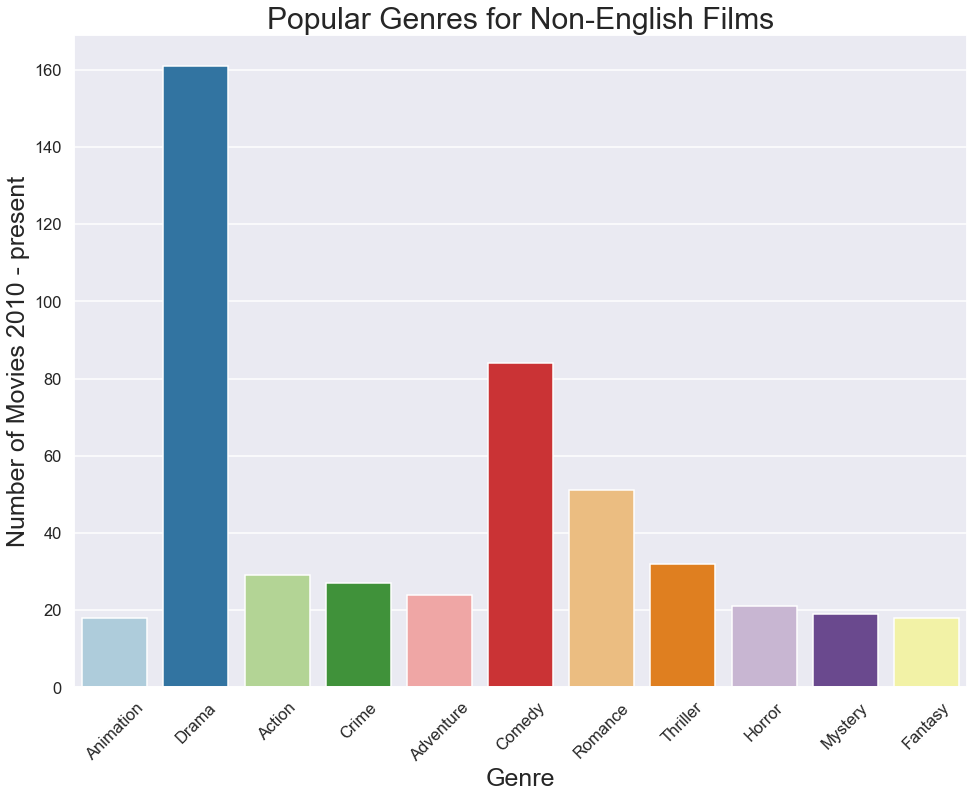

In [126]:
#plotting a bar chart of genre and count dictionary
f, ax = plt.subplots(figsize=(16,12))
sns.axes_style('darkgrid')
sns.set_context('talk') 
sns.barplot(x_genre_count, y_genre_count, palette='Paired')
plt.title('Popular Genres for Non-English Films', fontsize=30)
plt.xticks(rotation=45)
plt.ylabel('Number of Movies 2010 - present', fontsize=25)
plt.xlabel('Genre', fontsize=25) 
plt.show()

In [71]:
#create additional visualization of vote averages and viewing our dataset
non_en_movie_details_df.head()

,primary_title,original_title,start_year,genres,id,original_language,popularity,release_date,title,vote_average,...,Mystery,War,History,Fantasy,Music,Sci-Fi,Family,Musical,Sport,Western
221,The Illusionist,L'illusionniste,2010,"[Animation, Drama]",41201,fr,8.404,2010-12-25,The Illusionist,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,The Whistleblower,The Whistleblower,2010,"[Action, Biography, Crime]",65760,uk,9.578,2011-08-05,The Whistleblower,6.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,A Monster in Paris,Un monstre à Paris,2011,"[Adventure, Animation, Comedy]",77459,fr,7.852,2011-11-22,A Monster in Paris,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710,Certified Copy,Copie conforme,2010,"[Drama, Romance]",48303,fr,7.858,2011-03-11,Certified Copy,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
904,Tomboy,Tomboy,2020,[Documentary],65229,fr,7.258,2011-11-16,Tomboy,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
#create long form of our df so each title/genre pairing has its own row
long_non_en_movie_details_df = pd.melt(non_en_movie_details_df, \
            id_vars = ['original_title', 'vote_average'], value_vars = cols)

In [73]:
#confirm change from wide to long df
long_non_en_movie_details_df.head()

,original_title,vote_average,variable,value
0,L'illusionniste,7.4,Animation,1.0
1,The Whistleblower,6.7,Animation,NaN
2,Un monstre à Paris,6.6,Animation,1.0
3,Copie conforme,7.2,Animation,NaN
4,Tomboy,7.2,Animation,NaN


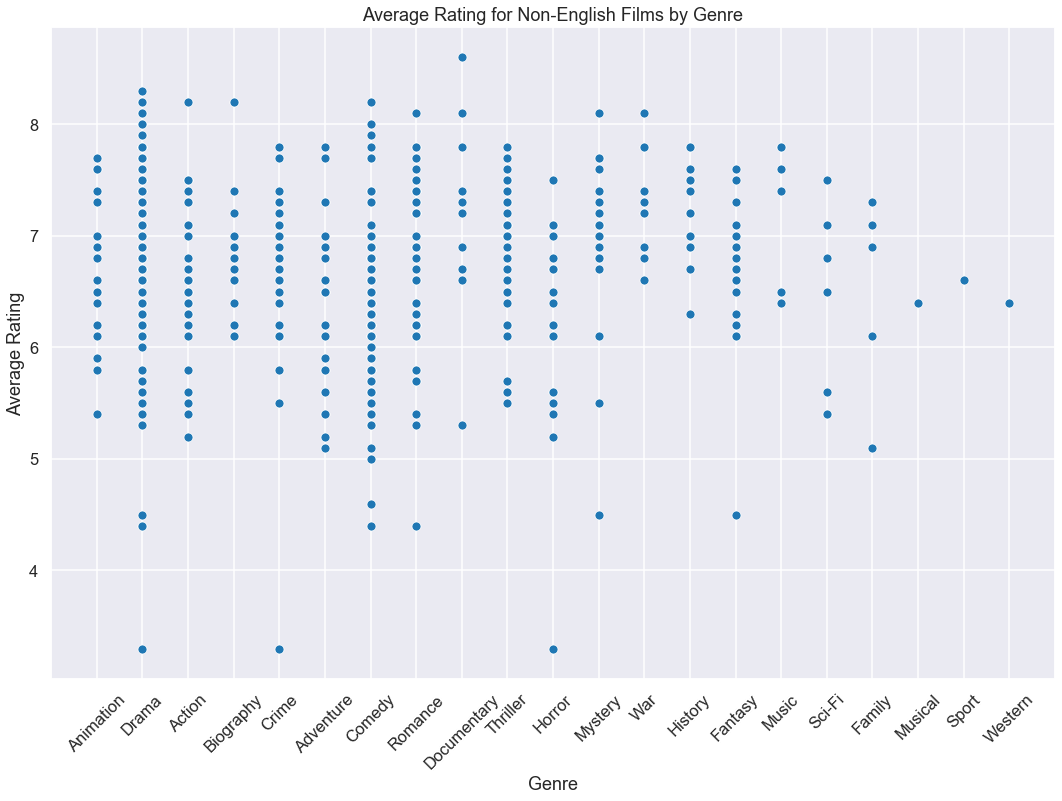

In [128]:
#plot scatterplot of average voter rating of each movie by genre
rating_x = long_non_en_movie_details_df['variable']
rating_y = long_non_en_movie_details_df.loc\
        [long_non_en_movie_details_df['value']== True, 'vote_average']
f, ax = plt.subplots(figsize=(18,12))
sns.set_style('darkgrid')
sns.set_context('talk') 
sns.scatterplot(rating_x, rating_y, palette='Set3')
plt.title('Average Rating for Non-English Films by Genre')
plt.xticks(rotation=45)
plt.ylabel('Average Rating')
plt.xlabel('Genre') 
plt.show()

In [ ]:
#create an SQL table from our long data set
#(not run in this instance since table had been created in prior kernel and produces an error message)
long_non_en_movie_details_df.to_sql('non_en_movie_details', conn)

In [76]:
#run SQL query for average voter rating by genre
cur.execute("""SELECT variable,
            AVG(vote_average) AS genre_average,  
            COUNT(variable) AS number_films
            FROM non_en_movie_details
            WHERE value = 1.0
            GROUP BY variable
            ORDER BY AVG(vote_average) DESC;""")
genre_df = pd.DataFrame(cur.fetchall())
genre_df.columns = [i[0] for i in cur.description]
genre_df

,variable,genre_average,number_films
0,War,7.310000,10
1,Music,7.250000,6
2,History,7.200000,14
3,Documentary,7.190000,10
4,Mystery,6.926316,19
5,Drama,6.893789,161
6,Biography,6.881250,16
7,Thriller,6.825000,32
8,Romance,6.760784,51
9,Animation,6.700000,18


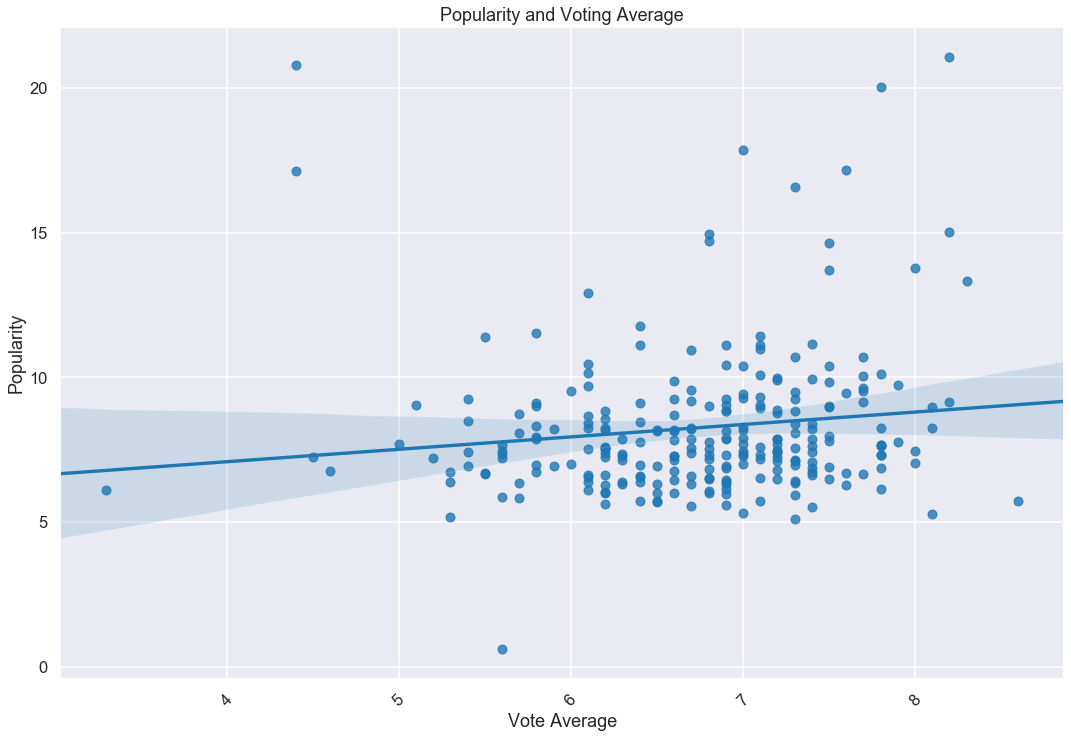

In [129]:
#since we have a separate column on 'popularity' in addition to voting, 
#plot the popularity against the vote average
#check correlation between vote average and popularity
popularity_and_voting_x = non_en_movie_details_df['vote_average']
popularity_and_voting_y = non_en_movie_details_df['popularity']
f, ax = plt.subplots(figsize=(18,12))
sns.axes_style('darkgrid')
sns.set_context('talk') 
sns.regplot(popularity_and_voting_x, popularity_and_voting_y)
plt.title('Popularity and Voting Average')
plt.xticks(rotation=45)
plt.ylabel('Popularity')
plt.xlabel('Vote Average') 
plt.show()

In [69]:
# confirm there is no correlation between vote average and popularity
non_en_movie_details_df.corr()

,start_year,id,popularity,vote_average,vote_count,Animation,Drama,Action,Biography,Crime,...,Mystery,War,History,Fantasy,Music,Sci-Fi,Family,Musical,Sport,Western
start_year,1.000000,0.782352,0.059249,0.013933,-0.070101,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,0.782352,1.000000,0.192613,0.048509,-0.047919,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,0.059249,0.192613,1.000000,0.132982,0.384245,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vote_average,0.013933,0.048509,0.132982,1.000000,0.246060,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vote_count,-0.070101,-0.047919,0.384245,0.246060,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Animation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Biography,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Crime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Findings

Non-English Drama and Comedy are likely to attract more viewers.


## Recommendations

If Microsoft Studio decides to go ahead with production and distribution of foreign films, drama and comedy would likely attract more viewers.

## Future Work 
We will need to explore further what foreign language films are appealing to moviegoers (and more profitable). We should also find additional sources to gauge moviegoer sentiment rather than the vote average and popularity from our dataset.

## Q3: What are the leading movie studios and their production budgets?

We will review the Box Office Magic, Rotten Tomatoes tables and our existing dataframe from the previous question to see which has the longest data set on studio information. We would like to determine which studios are releasing the most movies, and would like to compare the production budgets of those studios.

## EDA for Studios and Production Budgets

In [77]:
#check out our dataframe from the earlier DF with budget data
budgets_and_release_dates_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_profit,release_month
id,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,12
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,5
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,6
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,5
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,12


In [78]:
#create our df from the unzipped .csv file
rt_studios_df = files_dict['rt_movie_info']

In [79]:
#check the value counts for studios in this dataframe
rt_studios_df['studio'].value_counts()

Universal Pictures                35
Paramount Pictures                27
20th Century Fox                  26
Sony Pictures Classics            22
Warner Bros. Pictures             21
                                  ..
The Off Hours Film LLC             1
20th Century Fox Film Corporat     1
Disneynature                       1
Sony Pictures/TriStar Pictures     1
Independent Films                  1
Name: studio, Length: 200, dtype: int64

In [81]:
##the above dataset looks too short to use 
##create our df from the unzipped .csv file to see if this is a more complete dataset
bom_studios_df = files_dict['bom_movie_gross']

In [82]:
#review the columns in our dataframe
bom_studios_df.head()

,studio,domestic_gross,foreign_gross,year
title,,,,
Toy Story 3,BV,415000000.0,652000000,2010
Alice in Wonderland (2010),BV,334200000.0,691300000,2010
Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
Inception,WB,292600000.0,535700000,2010
Shrek Forever After,P/DW,238700000.0,513900000,2010


In [83]:
bom_studios_df.reset_index(inplace = True)

In [84]:
bom_studios_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [85]:
#check out the duplicate rows
duplicate_bom_studios_df = bom_studios_df[bom_studios_df.duplicated()]

In [86]:
#identify that there are duplicates to remove
duplicate_bom_studios_df

,title,studio,domestic_gross,foreign_gross,year


In [87]:
#drop duplicate rows
bom_studios_df = bom_studios_df.drop_duplicates()

In [88]:
#confirm the duplicate rows have been dropped
duplicate_bom_studios_df = bom_studios_df[bom_studios_df.duplicated()]
duplicate_bom_studios_df

,title,studio,domestic_gross,foreign_gross,year


In [89]:
#pull the value counts for each studio
bom_studios_df['studio'].value_counts()

IFC      166
Uni.     147
WB       140
Fox      136
Magn.    136
        ... 
HC         1
BSC        1
TA         1
SDS        1
TAFC       1
Name: studio, Length: 257, dtype: int64

## Data Review

In [90]:
#check how far back our studio data goes
bom_studios_df['year'].min()

2010

In [91]:
#check how recent our studio data is
bom_studios_df['year'].max()

2018

In [92]:
bom_studios_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 158.8+ KB


In [93]:
#set the columns as studios and value counts in a new df 
#so we can pull top studio
top_studios_df = bom_studios_df['studio'].value_counts().reset_index()
top_studios_df.columns = ['studio', 'count']

In [94]:
#limit to only studios that have released over a hundred films in the last decade
top_studios_df = top_studios_df[top_studios_df['count'] >= 100]

In [95]:
bom_studios_df.reset_index(inplace = True)

In [96]:
bom_studios_df.index

RangeIndex(start=0, stop=3387, step=1)

In [97]:
#merge our existing budgets and release dates df with our BOM studios list on movie name
studio_budget_details_df = pd.merge(bom_studios_df,\
                                    budgets_and_release_dates_df,\
                                    left_on='title', right_on='movie',\
                                    how = 'inner')

In [98]:
#view our df
studio_budget_details_df

,index,title,studio,domestic_gross_x,foreign_gross,year,release_date,movie,production_budget,domestic_gross_y,worldwide_gross,movie_profit,release_month
0,0,Toy Story 3,BV,415000000.0,652000000,2010,2010-06-18,Toy Story 3,200000000,415004880,1068879522,868879522,6
1,3,Inception,WB,292600000.0,535700000,2010,2010-07-16,Inception,160000000,292576195,835524642,675524642,7
2,4,Shrek Forever After,P/DW,238700000.0,513900000,2010,2010-05-21,Shrek Forever After,165000000,238736787,756244673,591244673,5
3,5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,2010-06-30,The Twilight Saga: Eclipse,68000000,300531751,706102828,638102828,6
4,6,Iron Man 2,Par.,312400000.0,311500000,2010,2010-05-07,Iron Man 2,170000000,312433331,621156389,451156389,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,3253,Gotti,VE,4300000.0,NaN,2018,2018-06-15,Gotti,10000000,4286367,6089100,-3910900,6
1243,3259,Ben is Back,RAtt.,3700000.0,NaN,2018,2018-12-07,Ben is Back,13000000,3703182,9633111,-3366889,12
1244,3271,Bilal: A New Breed of Hero,VE,491000.0,1700000,2018,2018-02-02,Bilal: A New Breed of Hero,30000000,490973,648599,-29351401,2
1245,3279,Mandy,RLJ,1200000.0,NaN,2018,2018-09-14,Mandy,6000000,1214525,1427656,-4572344,9


In [99]:
#create grouped df with only our studio and 
##year with the sum of production budget by year
studio_budget_year_df = studio_budget_details_df.groupby(['studio', 'year'],\
                        as_index = False)['production_budget'].sum()

In [100]:
#view this new df
studio_budget_year_df.head()

,studio,year,production_budget
0,3D,2010,5000000
1,A24,2013,7500000
2,A24,2014,34500000
3,A24,2015,36000000
4,A24,2016,15000000


## Data Visualization

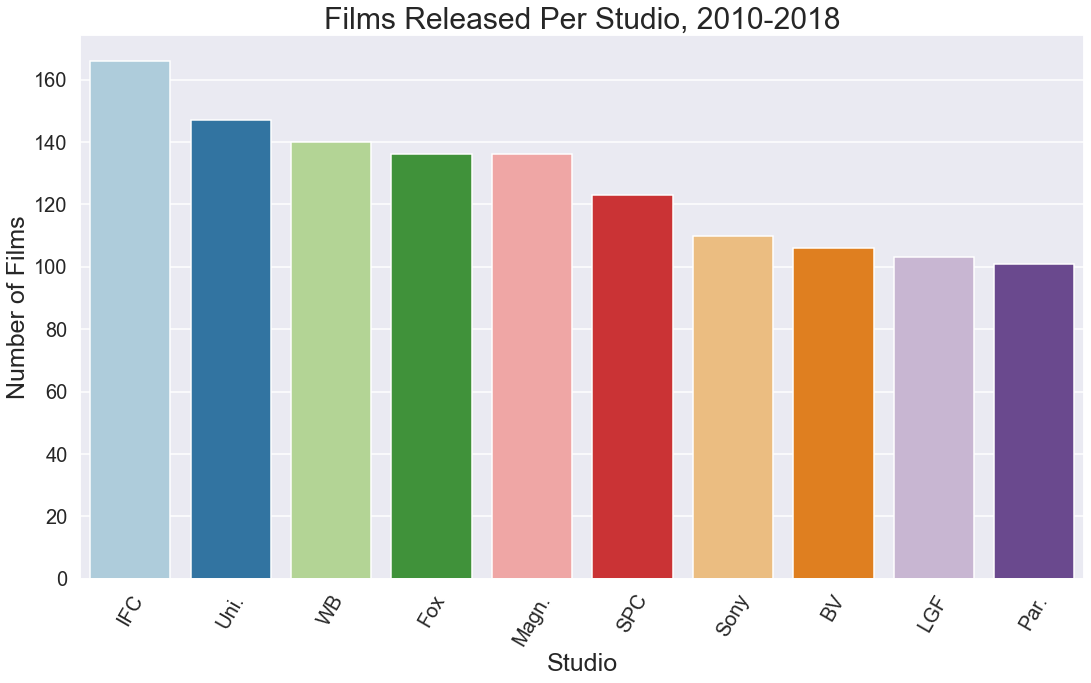

In [104]:
#create our first visualization of the prior-made top studios df that
#doesn't contain budget information, only studios with 100+ films in the past decade
studios_x = top_studios_df['studio']
studios_y = top_studios_df['count']
f, ax = plt.subplots(figsize=(18,10))
sns.set_style('darkgrid')
sns.set_context('talk') 
sns.barplot(studios_x, studios_y, palette='Paired')
plt.title('Films Released Per Studio, 2010-2018', fontsize=30)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Number of Films', fontsize = 25)
plt.xlabel('Studio', fontsize = 25) 
plt.show()

In [105]:
#view most films released in the past 10 years df to confirm # of rows
top_studios_df

,studio,count
0,IFC,166
1,Uni.,147
2,WB,140
3,Fox,136
4,Magn.,136
5,SPC,123
6,Sony,110
7,BV,106
8,LGF,103
9,Par.,101


In [106]:
#create list of studios column
studio_list = top_studios_df['studio'].tolist()

In [107]:
#view list
studio_list

['IFC', 'Uni.', 'WB', 'Fox', 'Magn.', 'SPC', 'Sony', 'BV', 'LGF', 'Par.']

In [108]:
#pull list of studios in our df with budgets for studios by year
studio_budget_year_df.studio.unique()

array(['3D', 'A24', 'ALP', 'ATO', 'Affirm', 'Alc', 'Amazon', 'Anch.',
       'Annapurna', 'App.', 'BBC', 'BG', 'BH Tilt', 'BSC', 'BST', 'BV',
       'CBS', 'CE', 'CJ', 'Cleopatra', 'Cohen', 'DR', 'Drft.', 'EC',
       'ELS', 'ENTMP', 'EOne', 'Eros', 'FCW', 'FD', 'First', 'Focus',
       'Fox', 'FoxS', 'Free', 'GK', 'Global Road', 'Gold.', 'GrtIndia',
       'IFC', 'IM', 'IVP', 'IW', 'Jan.', 'KE', 'Kino', 'LD', 'LG/S',
       'LGF', 'LGP', 'MBox', 'MGM', 'MNE', 'Magn.', 'Mira.', 'Mont.',
       'NFC', 'NM', 'Neon', 'OMNI/FSR', 'ORF', 'Orch.', 'Osci.', 'Over.',
       'P/DW', 'P4', 'PFR', 'PH', 'PNT', 'Par.', 'ParV', 'RAtt.', 'RLJ',
       'RTWC', 'Rela.', 'Relbig.', 'SGem', 'SMod', 'SPC', 'STX', 'Saban',
       'Scre.', 'Sony', 'Strand', 'Studio 8', 'Sum.', 'TFA', 'TriS',
       'Trib.', 'UTV', 'Uni.', 'VE', 'Viv.', 'W/Dim.', 'WB', 'WB (NL)',
       'WHE', 'Wein.', 'Yash'], dtype=object)

In [109]:
#trim down df to only those in our list of 10 studios
top_10_studios_df = studio_budget_year_df[studio_budget_year_df['studio']\
                                          .isin(studio_list)]

top_10_studios_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 30 to 278
Data columns (total 3 columns):
studio               84 non-null object
year                 84 non-null int64
production_budget    84 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.6+ KB


In [110]:
#confirm unique names of studios 
top_10_studios_df.studio.unique()

array(['BV', 'Fox', 'IFC', 'LGF', 'Magn.', 'Par.', 'SPC', 'Sony', 'Uni.',
       'WB'], dtype=object)

In [ ]:
#create SQL table of our studio/production budget df
#(not run in this instance since table had been created in prior kernel and produces an error message)
top_10_studios_df.to_sql('top_10_studios', conn)

In [112]:
#run SQL query for average production budget in release year by studio
cur.execute("""SELECT studio,
            AVG(production_budget) AS avg_yrly_budget
            FROM top_10_studios
            GROUP BY studio
            ORDER BY avg_yrly_budget DESC;""")
yrly_budget_df = pd.DataFrame(cur.fetchall())
yrly_budget_df.columns = [i[0] for i in cur.description]
yrly_budget_df

,studio,avg_yrly_budget
0,BV,1.050089e+09
1,WB,9.108556e+08
2,Fox,8.617222e+08
3,Uni.,7.330778e+08
4,Sony,5.611667e+08
5,Par.,5.300000e+08
6,LGF,2.299320e+08
7,SPC,4.437000e+07
8,IFC,3.875250e+07
9,Magn.,2.522000e+07


In [113]:
#group by studios so we can create subplot of production budgets for each studio
grouped_studios_df = top_10_studios_df.groupby('studio')

In [114]:
#confirm the change
grouped_studios_df.head()

,studio,year,production_budget
30,BV,2010,775000000
31,BV,2011,1084600000
32,BV,2012,785000000
33,BV,2013,1058000000
34,BV,2014,937200000
77,Fox,2010,757500000
78,Fox,2011,702000000
79,Fox,2012,746500000
80,Fox,2013,1048000000
81,Fox,2014,1313000000


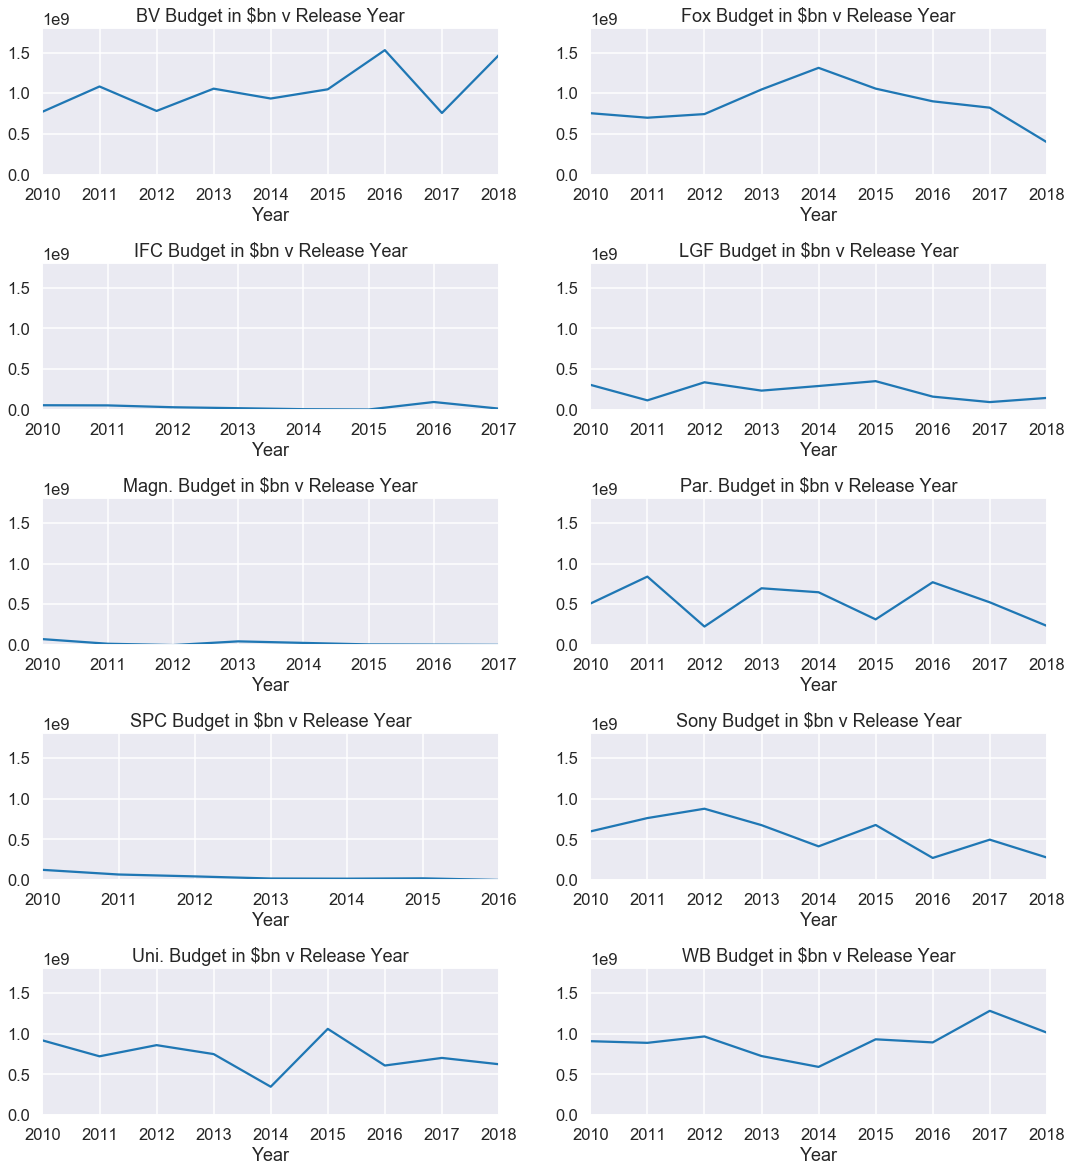

In [130]:
#create a 5x2 grid of subplots using for loops and enumerate to create individual
#axes passing the index into the 3rd tuple value of the subplot which 
#determines the number of each axis. 
plt.figure(figsize=(18,20))
for index, (studio, production_budget) in enumerate(grouped_studios_df):
    ax = plt.subplot(5, 2, index+1)
    production_budget.plot(x='year', y='production_budget', ax=ax, legend=False)
    ax.set_title(studio + ' Budget in $bn v Release Year', loc='center')
    ax.set_xlabel('Year')
    ax.set_ylim(0, 1800000000)
plt.subplots_adjust(hspace = .6)

## Findings

The major film studios,(Warner Bros, Universal, Paramount, Fox and BV) as presumed, regularly have bigger annual production budgets (of approx. $1bn) than smaller independent distributors ( such as Sony Pictures Classic, Magnolia Studios and IFC) that acquire and distribute films.

## Recommendations

Microsoft should consider the prospect of attaching its name to film acquisition and distribution rather than original production. As these lower budget movies still made it to top 10 together with the major film, it might be an appropriate model to enter the industry. 

## Future Work

In order to get a sense of viability, we will need to gauge the actual profitability of the acquisition and distribution model as compared to original production model.

## Conclusion

From the above analysis, we can conclude by summarizing our findings and recommend the following:

1. We recommend entering the movie industry through an acquisition/distribution model as more top movies can be 
   produced at a lower budget than producing an original movie as major film studios do.
2. Although there is wide variety of popular genre in foreign language film, we recommend choosing Drama or Comedy 
   genre if the business decides to go with a foreign language film production or distribution.
3. We would recommend planning for movie releases towards the summer or at the end of the year. It is important to 
   point out that the month of June has recorded both huge profits and huge losses too.